In [1]:
# Step 1: Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
# Step 2: Load data
df = pd.read_excel("ENB2012_data.xlsx")
X = df.iloc[:, 0:8].values
y = df.iloc[:, 8].values  # Heating Load (Y1)

In [3]:

# Step 3: Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [4]:

# Step 4: Model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Step 5: Train
def train_model(model, loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for features, targets in loader:
            optimizer.zero_grad()
            preds = model(features)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()

train_model(model, train_loader, criterion, optimizer)


In [7]:
# Step 6: Evaluate
def evaluate(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for features, targets in loader:
            out = model(features)
            preds.append(out.numpy())
            actuals.append(targets.numpy())
    return np.vstack(preds), np.vstack(actuals)

preds, actuals = evaluate(model, test_loader)

mse = mean_squared_error(actuals, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 2.52
MAE: 1.67
R²: 0.94


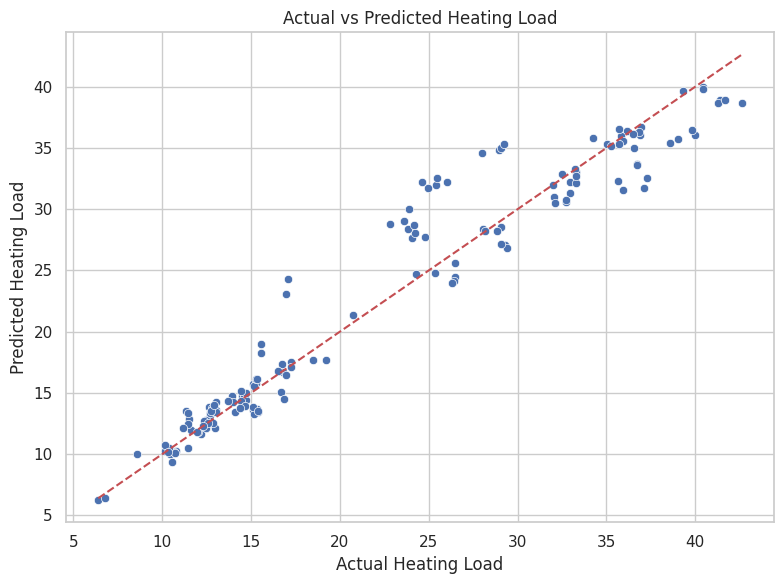

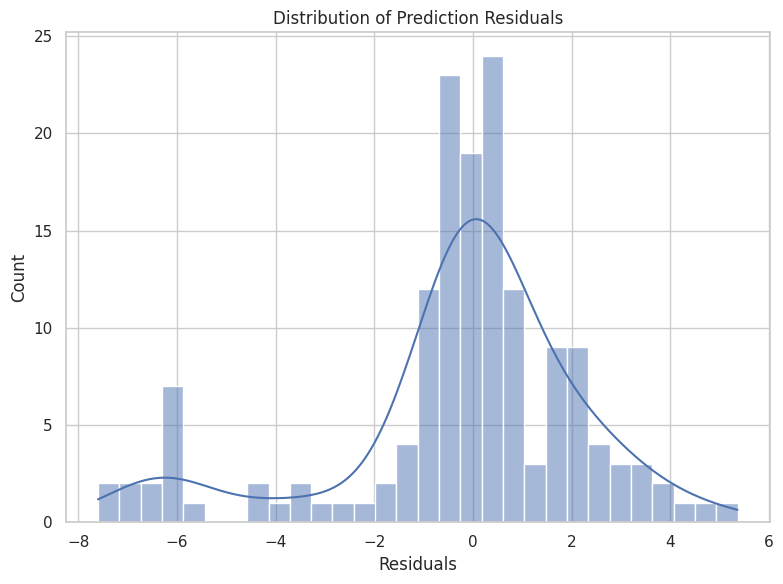

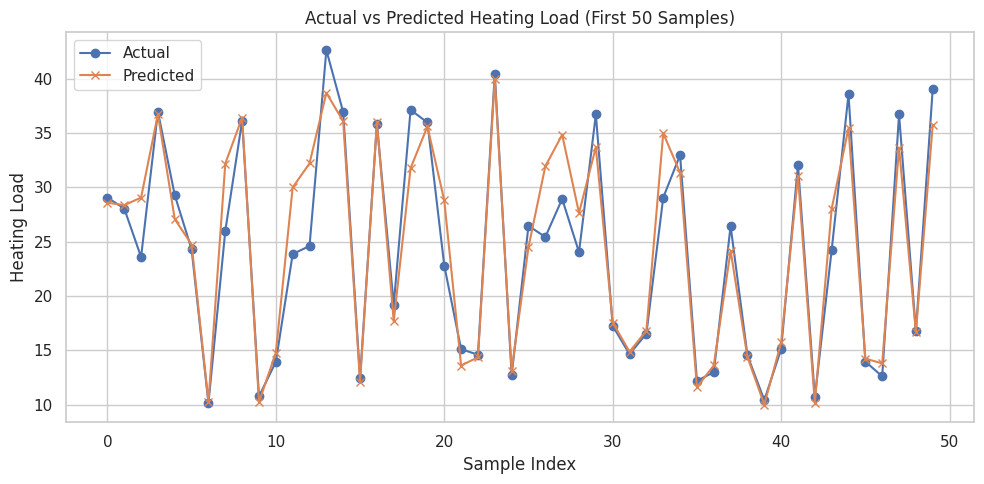

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals.flatten(), y=preds.flatten())
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel("Actual Heating Load")
plt.ylabel("Predicted Heating Load")
plt.title("Actual vs Predicted Heating Load")
plt.tight_layout()
plt.show()

# 2. Residuals distribution
residuals = actuals.flatten() - preds.flatten()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Prediction Residuals")
plt.tight_layout()
plt.show()

# 3. Line plot for first 50 samples
plt.figure(figsize=(10, 5))
plt.plot(actuals[:50], label='Actual', marker='o')
plt.plot(preds[:50], label='Predicted', marker='x')
plt.title("Actual vs Predicted Heating Load (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Heating Load")
plt.legend()
plt.tight_layout()
plt.show()
